# 📊 Анализ пролонгации договоров

## Полный анализ клиентской базы и эффективности менеджеров

**Цели анализа:**
- Расчет коэффициентов пролонгации проектов
- Анализ эффективности менеджеров
- Выявление проектов, "возвращающихся" после перерыва
- Создание комплексной отчетности

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re

# Настройки отображения
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Библиотеки успешно загружены и настроены")

✅ Библиотеки успешно загружены и настроены


## 🔧 Подготовка финансовых данных

**Логика преобразования:**
- Конвертация русских названий месяцев в формат YYYY-MM
- Обработка различных форматов числовых данных
- Фильтрация некорректных значений
- Преобразование из широкого в длинный формат

In [4]:
def prepare_financial_data(financial_df):
    """Подготовка финансовых данных"""
    financial_df = financial_df.copy()
    month_columns = [col for col in financial_df.columns if 
                     col not in ['id', 'Причина дубля', 'Account', 'Unnamed: 0']]

    def convert_to_float(value):
        if pd.isna(value) or value is None:
            return 0.0
        if isinstance(value, (int, float)):
            return float(value)
        if isinstance(value, str):
            if value.lower() in ['стоп', 'stop', 'nan', '', 'в ноль', 'end']:
                return 0.0
            value_clean = re.sub(r'[^\d,.]', '', value.replace(' ', ''))
            value_clean = value_clean.replace(',', '.')
            try:
                return float(value_clean)
            except ValueError:
                return 0.0
        return 0.0

    for col in month_columns:
        financial_df[col] = financial_df[col].apply(convert_to_float)

    financial_long = pd.melt(
        financial_df,
        id_vars=['id', 'Причина дубля', 'Account'],
        value_vars=month_columns,
        var_name='month',
        value_name='shipment_amount'
    )

    def convert_russian_month(month_str):
        month_mapping = {
            'январь': '01', 'февраль': '02', 'март': '03', 'апрель': '04',
            'май': '05', 'июнь': '06', 'июль': '07', 'август': '08',
            'сентябрь': '09', 'октябрь': '10', 'ноябрь': '11', 'декабрь': '12'
        }
        try:
            parts = month_str.split()
            if len(parts) == 2:
                month_ru = parts[0].lower()
                year = parts[1]
                if month_ru in month_mapping:
                    month_num = month_mapping[month_ru]
                    return f"{year}-{month_num}"
        except Exception:
            pass
        return month_str

    financial_long['month'] = financial_long['month'].apply(convert_russian_month)
    financial_long = financial_long[financial_long['shipment_amount'] >= 0]
    financial_long = financial_long.sort_values('shipment_amount', ascending=False)
    financial_long = financial_long.drop_duplicates(['id', 'month'], keep='first')

    return financial_long

print("✅ Функция prepare_financial_data создана")

✅ Функция prepare_financial_data создана


Вспомогательные функции

In [5]:
def get_previous_month(month):
    """Получение предыдущего месяца в формате YYYY-MM"""
    try:
        year = int(month.split('-')[0])
        month_num = int(month.split('-')[1])
        if month_num == 1:
            return f"{year - 1}-12"
        else:
            return f"{year}-{month_num - 1:02d}"
    except Exception:
        return month

def get_next_month(month):
    """Получение следующего месяца в формате YYYY-MM"""
    try:
        year = int(month.split('-')[0])
        month_num = int(month.split('-')[1])
        if month_num == 12:
            return f"{year + 1}-01"
        else:
            return f"{year}-{month_num + 1:02d}"
    except Exception:
        return month

def get_shipment_amount(project_id, month, financial_long_data):
    """Получение суммы отгрузки проекта в указанном месяце"""
    shipment = financial_long_data[
        (financial_long_data['id'] == project_id) &
        (financial_long_data['month'] == month)
        ]['shipment_amount']
    return shipment.sum() if not shipment.empty else 0.0

def get_projects_with_shipment_in_month(month, financial_long_data):
    """Получение проектов, имевших отгрузки в указанном месяце"""
    projects = financial_long_data[
        (financial_long_data['month'] == month) &
        (financial_long_data['shipment_amount'] > 0)
        ]['id'].unique()
    return list(projects)

print("✅ Вспомогательные функции созданы")

✅ Вспомогательные функции созданы


Расчет первого коэффициента

In [6]:
def calculate_first_prolongation_coefficient(financial_long_data):
    """Расчет первого коэффициента пролонгации"""
    print("\n" + "=" * 60)
    print("🧮 РАСЧЕТ ПЕРВОГО КОЭФФИЦИЕНТА ПРОЛОНГАЦИИ")
    print("=" * 60)

    results_list = []
    all_months = sorted(financial_long_data['month'].unique())

    for i, current_month in enumerate(all_months[1:], 1):
        prev_month = all_months[i - 1]

        print(f"\n📅 Анализ месяца: {current_month}")
        print(f"   Проекты с отгрузками в: {prev_month}")

        projects_with_prev_shipment = get_projects_with_shipment_in_month(prev_month, financial_long_data)
        print(f"   Проектов с отгрузками в {prev_month}: {len(projects_with_prev_shipment)}")

        continued_projects = []
        continued_shipment = 0
        for project in projects_with_prev_shipment:
            current_shipment = get_shipment_amount(project, current_month, financial_long_data)
            if current_shipment > 0:
                continued_projects.append(project)
                continued_shipment += current_shipment

        print(f"   Пролонгировано проектов: {len(continued_projects)}")

        total_prev_shipment = 0
        for project in projects_with_prev_shipment:
            total_prev_shipment += get_shipment_amount(project, prev_month, financial_long_data)

        print(f"   Сумма отгрузок в {prev_month}: {total_prev_shipment:,.0f}")
        print(f"   Сумма пролонгированных отгрузок: {continued_shipment:,.0f}")

        if total_prev_shipment > 0:
            prolongation_rate = continued_shipment / total_prev_shipment
            print(f"   📊 Коэффициент пролонгации: {prolongation_rate:.2%}")
        else:
            prolongation_rate = 0
            print(f"   📊 Коэффициент пролонгации: 0.00% (нет отгрузок в предыдущем месяце)")

        month_result = {
            'month': current_month,
            'previous_month': prev_month,
            'projects_with_prev_shipment': len(projects_with_prev_shipment),
            'prolongated_projects': len(continued_projects),
            'total_prev_shipment': total_prev_shipment,
            'prolongated_shipment': continued_shipment,
            'prolongation_rate': prolongation_rate
        }
        results_list.append(month_result)

    return pd.DataFrame(results_list)

print("✅ Функция calculate_first_prolongation_coefficient создана")

✅ Функция calculate_first_prolongation_coefficient создана


Расчет второго коэффициента

In [7]:
def calculate_second_prolongation_coefficient_corrected(month, financial_long_data):
    """
    ПРАВИЛЬНЫЙ расчет коэффициента пролонгации во второй месяц
    Пример для мая: проекты с отгрузкой в марте, без отгрузки в апреле, но с отгрузкой в мае
    """
    completion_month = get_previous_month(get_previous_month(month))
    first_prolongation_month = get_previous_month(month)
    second_prolongation_month = month

    print(f"\n🔍 ПРАВИЛЬНЫЙ расчет второго коэффициента для {month}:")
    print(f"   Отгрузки были в: {completion_month}")
    print(f"   Пропустили месяц: {first_prolongation_month}")
    print(f"   Вернулись в: {second_prolongation_month}")

    projects_with_completion_shipment = get_projects_with_shipment_in_month(completion_month, financial_long_data)
    print(f"   Проектов с отгрузками в {completion_month}: {len(projects_with_completion_shipment)}")

    projects_without_first_prolongation = []
    for project in projects_with_completion_shipment:
        first_prolongation_amount = get_shipment_amount(project, first_prolongation_month, financial_long_data)
        if first_prolongation_amount == 0:
            projects_without_first_prolongation.append(project)

    print(f"   Проектов БЕЗ отгрузки в {first_prolongation_month}: {len(projects_without_first_prolongation)}")

    total_completion_amount = 0
    completion_shipments = []
    for project in projects_without_first_prolongation:
        completion_amount = get_shipment_amount(project, completion_month, financial_long_data)
        total_completion_amount += completion_amount
        completion_shipments.append((project, completion_amount))

    total_second_prolongation_amount = 0
    prolonged_projects_second = []
    for project in projects_without_first_prolongation:
        second_prolongation_amount = get_shipment_amount(project, second_prolongation_month, financial_long_data)
        if second_prolongation_amount > 0:
            total_second_prolongation_amount += second_prolongation_amount
            prolonged_projects_second.append((project, second_prolongation_amount))

    print(f"   Пролонгировано во второй месяц: {len(prolonged_projects_second)}")
    print(f"   Сумма отгрузок в {completion_month}: {total_completion_amount:,.0f}")
    print(f"   Сумма пролонгации во второй месяц: {total_second_prolongation_amount:,.0f}")

    if prolonged_projects_second:
        print(f"   📋 Примеры пролонгированных проектов: {[p[0] for p in prolonged_projects_second[:3]]}")

    if total_completion_amount > 0:
        coefficient = (total_second_prolongation_amount / total_completion_amount) * 100
        print(f"   📊 Второй коэффициент пролонгации: {coefficient:.2f}%")
    else:
        coefficient = 0
        print(f"   📊 Второй коэффициент пролонгации: 0.00% (нет отгрузок в базовом месяце)")

    return {
        'month': month,
        'completion_month': completion_month,
        'first_prolongation_month': first_prolongation_month,
        'projects_count': len(projects_without_first_prolongation),
        'prolonged_count_second': len(prolonged_projects_second),
        'total_completion_amount': total_completion_amount,
        'total_second_prolongation_amount': total_second_prolongation_amount,
        'coefficient_second': coefficient,
        'prolonged_projects': [p[0] for p in prolonged_projects_second]
    }

print("✅ Функция calculate_second_prolongation_coefficient_corrected создана")

✅ Функция calculate_second_prolongation_coefficient_corrected создана


 Анализ по менеджерам 

In [8]:
def calculate_manager_prolongation_metrics(financial_long_data, prolongations_data):
    """
    Расчет коэффициентов пролонгации по каждому менеджеру
    """
    print("\n" + "=" * 60)
    print("👥 РАСЧЕТ КОЭФФИЦИЕНТОВ ПО МЕНЕДЖЕРАМ")
    print("=" * 60)

    project_managers = prolongations_data[['id', 'AM']].drop_duplicates()

    financial_with_managers = financial_long_data.merge(
        project_managers,
        on='id',
        how='left',
        suffixes=('', '_prolongation')
    )

    financial_with_managers['AM'] = financial_with_managers['AM'].fillna('без А/М')

    analysis_months_2023 = [month for month in sorted(financial_long_data['month'].unique())
                            if month.startswith('2023')]

    manager_results_list = []

    for month in analysis_months_2023[:6]:
        prev_month = get_previous_month(month)

        print(f"\n📅 Анализ месяца {month}:")

        managers = financial_with_managers['AM'].unique()

        for manager in managers:
            manager_projects_prev = financial_with_managers[
                (financial_with_managers['AM'] == manager) &
                (financial_with_managers['month'] == prev_month) &
                (financial_with_managers['shipment_amount'] > 0)
                ]['id'].unique()

            if len(manager_projects_prev) > 0:
                continued_projects = financial_with_managers[
                    (financial_with_managers['AM'] == manager) &
                    (financial_with_managers['id'].isin(manager_projects_prev)) &
                    (financial_with_managers['month'] == month) &
                    (financial_with_managers['shipment_amount'] > 0)
                    ]

                total_prev_shipment = financial_with_managers[
                    (financial_with_managers['AM'] == manager) &
                    (financial_with_managers['id'].isin(manager_projects_prev)) &
                    (financial_with_managers['month'] == prev_month)
                    ]['shipment_amount'].sum()

                continued_shipment = continued_projects['shipment_amount'].sum()

                if total_prev_shipment > 0:
                    prolongation_rate = (continued_shipment / total_prev_shipment) * 100
                else:
                    prolongation_rate = 0

                manager_results_list.append({
                    'month': month,
                    'manager': manager,
                    'projects_with_prev_shipment': len(manager_projects_prev),
                    'prolongated_projects': len(continued_projects),
                    'total_prev_shipment': total_prev_shipment,
                    'prolongated_shipment': continued_shipment,
                    'prolongation_rate': prolongation_rate
                })

                if prolongation_rate > 0:
                    print(f"   👤 {manager}: {prolongation_rate:.1f}% ({len(continued_projects)}/{len(manager_projects_prev)} проектов)")

    return pd.DataFrame(manager_results_list)

print("✅ Функция calculate_manager_prolongation_metrics создана")

✅ Функция calculate_manager_prolongation_metrics создана


Визуализация

In [9]:
def create_visualizations(first_coeff_results, second_coeff_results):
    """Создание визуализаций"""
    print("\n" + "=" * 60)
    print("📊 ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
    print("=" * 60)

    if len(first_coeff_results) > 0:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

        # График 1: Динамика первого коэффициента пролонгации
        ax1.plot(first_coeff_results['month'], first_coeff_results['prolongation_rate'],
                 marker='o', linewidth=2, markersize=6, color='blue')
        ax1.set_title('Динамика первого коэффициента пролонгации', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Месяц')
        ax1.set_ylabel('Коэффициент пролонгации')
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(0, 1)

        for i, row in first_coeff_results.iterrows():
            ax1.annotate(f'{row["prolongation_rate"]:.1%}',
                         (row['month'], row['prolongation_rate']),
                         textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

        # График 2: Количество пролонгированных проектов
        ax2.bar(first_coeff_results['month'], first_coeff_results['prolongated_projects'],
                alpha=0.7, color='green')
        ax2.set_title('Количество пролонгированных проектов (1-й коэффициент)', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Месяц')
        ax2.set_ylabel('Количество проектов')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)

        for i, v in enumerate(first_coeff_results['prolongated_projects']):
            ax2.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=9)

        # График 3: Второй коэффициент пролонгации
        if second_coeff_results:
            second_coeff_df = pd.DataFrame(second_coeff_results)
            ax3.bar(second_coeff_df['month'], second_coeff_df['coefficient_second'] / 100,
                    alpha=0.7, color='orange')
            ax3.set_title('Второй коэффициент пролонгации', fontsize=14, fontweight='bold')
            ax3.set_xlabel('Месяц')
            ax3.set_ylabel('Коэффициент пролонгации')
            ax3.tick_params(axis='x', rotation=45)
            ax3.grid(True, alpha=0.3)
            ax3.set_ylim(0, 1)

            for i, row in second_coeff_df.iterrows():
                ax3.text(i, row['coefficient_second'] / 100 + 0.02,
                         f'{row["coefficient_second"]:.1f}%',
                         ha='center', va='bottom', fontsize=9)

        # График 4: Сравнение объемов отгрузок
        ax4.bar(first_coeff_results['month'], first_coeff_results['total_prev_shipment'] / 1000000,
                alpha=0.6, label='Общие отгрузки', color='blue')
        ax4.bar(first_coeff_results['month'], first_coeff_results['prolongated_shipment'] / 1000000,
                alpha=0.8, label='Пролонгированные', color='red')
        ax4.set_title('Объемы отгрузок (млн руб.)', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Месяц')
        ax4.set_ylabel('Сумма отгрузок, млн руб.')
        ax4.tick_params(axis='x', rotation=45)
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('improved_prolongation_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("✅ Графики сохранены в improved_prolongation_analysis.png")

print("✅ Функция create_visualizations создана")

✅ Функция create_visualizations создана


Создание отчета

In [10]:
def create_comprehensive_report(first_coeff_results, second_coeff_results, manager_results, financial_long_data):
    """
    Создание комплексного отчета
    """
    print("\n" + "=" * 60)
    print("💾 СОЗДАНИЕ КОМПЛЕКСНОГО ОТЧЕТА")
    print("=" * 60)

    with pd.ExcelWriter('comprehensive_prolongation_report.xlsx', engine='openpyxl') as writer:

        # 1. Сводка по отделу
        summary_data = {
            'Показатель': [
                'Средний коэффициент пролонгации (1-й)',
                'Средний коэффициент пролонгации (2-й)',
                'Всего пролонгировано проектов',
                'Общий объем пролонгированных отгрузок',
                'Период анализа',
                'Количество менеджеров'
            ],
            'Значение': [
                f"{first_coeff_results['prolongation_rate'].mean() * 100:.2f}%" if len(first_coeff_results) > 0 else "0.00%",
                f"{pd.DataFrame(second_coeff_results)['coefficient_second'].mean():.2f}%" if second_coeff_results else "0.00%",
                f"{first_coeff_results['prolongated_projects'].sum()}" if len(first_coeff_results) > 0 else "0",
                f"{first_coeff_results['prolongated_shipment'].sum():,.0f} руб." if len(first_coeff_results) > 0 else "0 руб.",
                f"{first_coeff_results['month'].min()} - {first_coeff_results['month'].max()}" if len(first_coeff_results) > 0 else "Нет данных",
                f"{manager_results['manager'].nunique()}" if len(manager_results) > 0 else "0"
            ]
        }
        pd.DataFrame(summary_data).to_excel(writer, sheet_name='Сводка по отделу', index=False)

        # 2. Детальные результаты по месяцам (1-й коэффициент)
        if len(first_coeff_results) > 0:
            results_with_percent = first_coeff_results.copy()
            results_with_percent['prolongation_rate_percent'] = results_with_percent['prolongation_rate'] * 100
            results_with_percent[['month', 'previous_month', 'projects_with_prev_shipment',
                                  'prolongated_projects', 'total_prev_shipment', 'prolongated_shipment',
                                  'prolongation_rate_percent']].to_excel(writer, sheet_name='1-й коэффициент',
                                                                         index=False)

        # 3. Второй коэффициент пролонгации
        if second_coeff_results:
            second_coeff_df = pd.DataFrame(second_coeff_results)
            second_coeff_df.to_excel(writer, sheet_name='2-й коэффициент', index=False)

        # 4. Результаты по менеджерам
        if len(manager_results) > 0:
            manager_summary = manager_results.groupby('manager').agg({
                'prolongation_rate': 'mean',
                'projects_with_prev_shipment': 'sum',
                'prolongated_projects': 'sum',
                'total_prev_shipment': 'sum',
                'prolongated_shipment': 'sum'
            }).reset_index()
            manager_summary['prolongation_rate'] = manager_summary['prolongation_rate'].round(2)
            manager_summary.to_excel(writer, sheet_name='Итоги по менеджерам', index=False)

            # Детальные данные по менеджерам
            manager_details = manager_results.copy()
            manager_details['prolongation_rate'] = manager_details['prolongation_rate'].round(2)
            manager_details.to_excel(writer, sheet_name='Детали по менеджерам', index=False)

        # 5. Топ менеджеров
        if len(manager_results) > 0:
            top_managers = manager_results.groupby('manager')['prolongation_rate'].mean().nlargest(5)
            pd.DataFrame({
                'Менеджер': top_managers.index,
                'Средний коэффициент': top_managers.values.round(2)
            }).to_excel(writer, sheet_name='Топ менеджеров', index=False)

        # 6. Исходные данные
        financial_long_data.head(1000).to_excel(writer, sheet_name='Исходные данные', index=False)

    print("✅ Комплексный отчет сохранен в comprehensive_prolongation_report.xlsx")

print("✅ Функция create_comprehensive_report создана")

✅ Функция create_comprehensive_report создана


Главная функция анализа 

In [11]:
def calculate_complete_prolongation_analysis():
    """Полный анализ пролонгации с исправленной логикой"""
    print("🚀 ЗАПУСК ИСПРАВЛЕННОГО АНАЛИЗА ПРОЛОНГАЦИЙ")
    print("=" * 60)

    # Загрузка данных
    print("📂 Загрузка данных...")
    prolongations_data = pd.read_csv('prolongations.csv')
    financial_data = pd.read_csv('financial_data.csv')
    print(f"✅ Загружено: prolongations.csv ({len(prolongations_data)} записей)")
    print(f"✅ Загружено: financial_data.csv ({len(financial_data)} записей)")

    # Подготовка данных
    print("\n🔧 Подготовка данных...")
    financial_long_prepared = prepare_financial_data(financial_data)
    print(f"✅ Подготовлено финансовых записей: {len(financial_long_prepared)}")

    # Расчет первого коэффициента пролонгации
    first_coeff_results = calculate_first_prolongation_coefficient(financial_long_prepared)

    # Расчет второго коэффициента пролонгации (ИСПРАВЛЕННЫЙ)
    print("\n" + "=" * 60)
    print("🔄 РАСЧЕТ ВТОРОГО КОЭФФИЦИЕНТА ПРОЛОНГАЦИИ (ИСПРАВЛЕННЫЙ)")
    print("=" * 60)

    second_coeff_results_list = []
    analysis_months_2023 = [month for month in sorted(financial_long_prepared['month'].unique())
                            if month.startswith('2023')]

    for month in analysis_months_2023[:6]:  # Анализируем первые 6 месяцев 2023
        try:
            second_coeff_data = calculate_second_prolongation_coefficient_corrected(month, financial_long_prepared)
            second_coeff_results_list.append(second_coeff_data)
        except Exception as e:
            print(f"❌ Ошибка при расчете второго коэффициента для {month}: {e}")

    # Расчет по менеджерам
    manager_results_df = calculate_manager_prolongation_metrics(financial_long_prepared, prolongations_data)

    # Визуализация результатов
    create_visualizations(first_coeff_results, second_coeff_results_list)

    # Создание комплексного отчета
    create_comprehensive_report(first_coeff_results, second_coeff_results_list, manager_results_df,
                                financial_long_prepared)

    # Сводная статистика
    print("\n" + "=" * 60)
    print("📈 СВОДНАЯ СТАТИСТИКА")
    print("=" * 60)

    if len(first_coeff_results) > 0:
        avg_prolongation_rate = first_coeff_results['prolongation_rate'].mean()
        total_prolongated_projects = first_coeff_results['prolongated_projects'].sum()
        total_prolongated_shipment = first_coeff_results['prolongated_shipment'].sum()

        print(f"📊 ОБЩИЕ РЕЗУЛЬТАТЫ:")
        print(f"   • Средний коэффициент пролонгации (1-й): {avg_prolongation_rate:.2%}")
        print(f"   • Всего пролонгировано проектов: {total_prolongated_projects}")
        print(f"   • Общий объем пролонгированных отгрузок: {total_prolongated_shipment:,.0f} руб.")
        print(f"   • Анализированный период: {first_coeff_results['month'].min()} - {first_coeff_results['month'].max()}")

        if second_coeff_results_list:
            second_avg = pd.DataFrame(second_coeff_results_list)['coefficient_second'].mean()
            print(f"   • Средний коэффициент пролонгации (2-й): {second_avg:.2f}%")

        # Лучшие месяцы по пролонгации
        best_months = first_coeff_results.nlargest(3, 'prolongation_rate')
        print(f"\n🏆 ЛУЧШИЕ МЕСЯЦЫ ПО ПРОЛОНГАЦИИ:")
        for _, row in best_months.iterrows():
            print(f"   • {row['month']}: {row['prolongation_rate']:.2%} ({row['prolongated_projects']} проектов)")

    return first_coeff_results, second_coeff_results_list, manager_results_df

print("✅ Функция calculate_complete_prolongation_analysis создана")

✅ Функция calculate_complete_prolongation_analysis создана


Финальный запуск

🎯 ЗАПУСК ПОЛНОГО АНАЛИЗА ПРОЛОНГАЦИИ
🚀 ЗАПУСК ИСПРАВЛЕННОГО АНАЛИЗА ПРОЛОНГАЦИЙ
📂 Загрузка данных...
✅ Загружено: prolongations.csv (477 записей)
✅ Загружено: financial_data.csv (451 записей)

🔧 Подготовка данных...
✅ Подготовлено финансовых записей: 5024

🧮 РАСЧЕТ ПЕРВОГО КОЭФФИЦИЕНТА ПРОЛОНГАЦИИ

📅 Анализ месяца: 2022-12
   Проекты с отгрузками в: 2022-11
   Проектов с отгрузками в 2022-11: 115
   Пролонгировано проектов: 96
   Сумма отгрузок в 2022-11: 11,210,997
   Сумма пролонгированных отгрузок: 10,318,521
   📊 Коэффициент пролонгации: 92.04%

📅 Анализ месяца: 2023-01
   Проекты с отгрузками в: 2022-12
   Проектов с отгрузками в 2022-12: 110
   Пролонгировано проектов: 78
   Сумма отгрузок в 2022-12: 12,362,138
   Сумма пролонгированных отгрузок: 8,508,677
   📊 Коэффициент пролонгации: 68.83%

📅 Анализ месяца: 2023-02
   Проекты с отгрузками в: 2023-01
   Проектов с отгрузками в 2023-01: 102
   Пролонгировано проектов: 89
   Сумма отгрузок в 2023-01: 10,236,494
   Сумма пролонгир

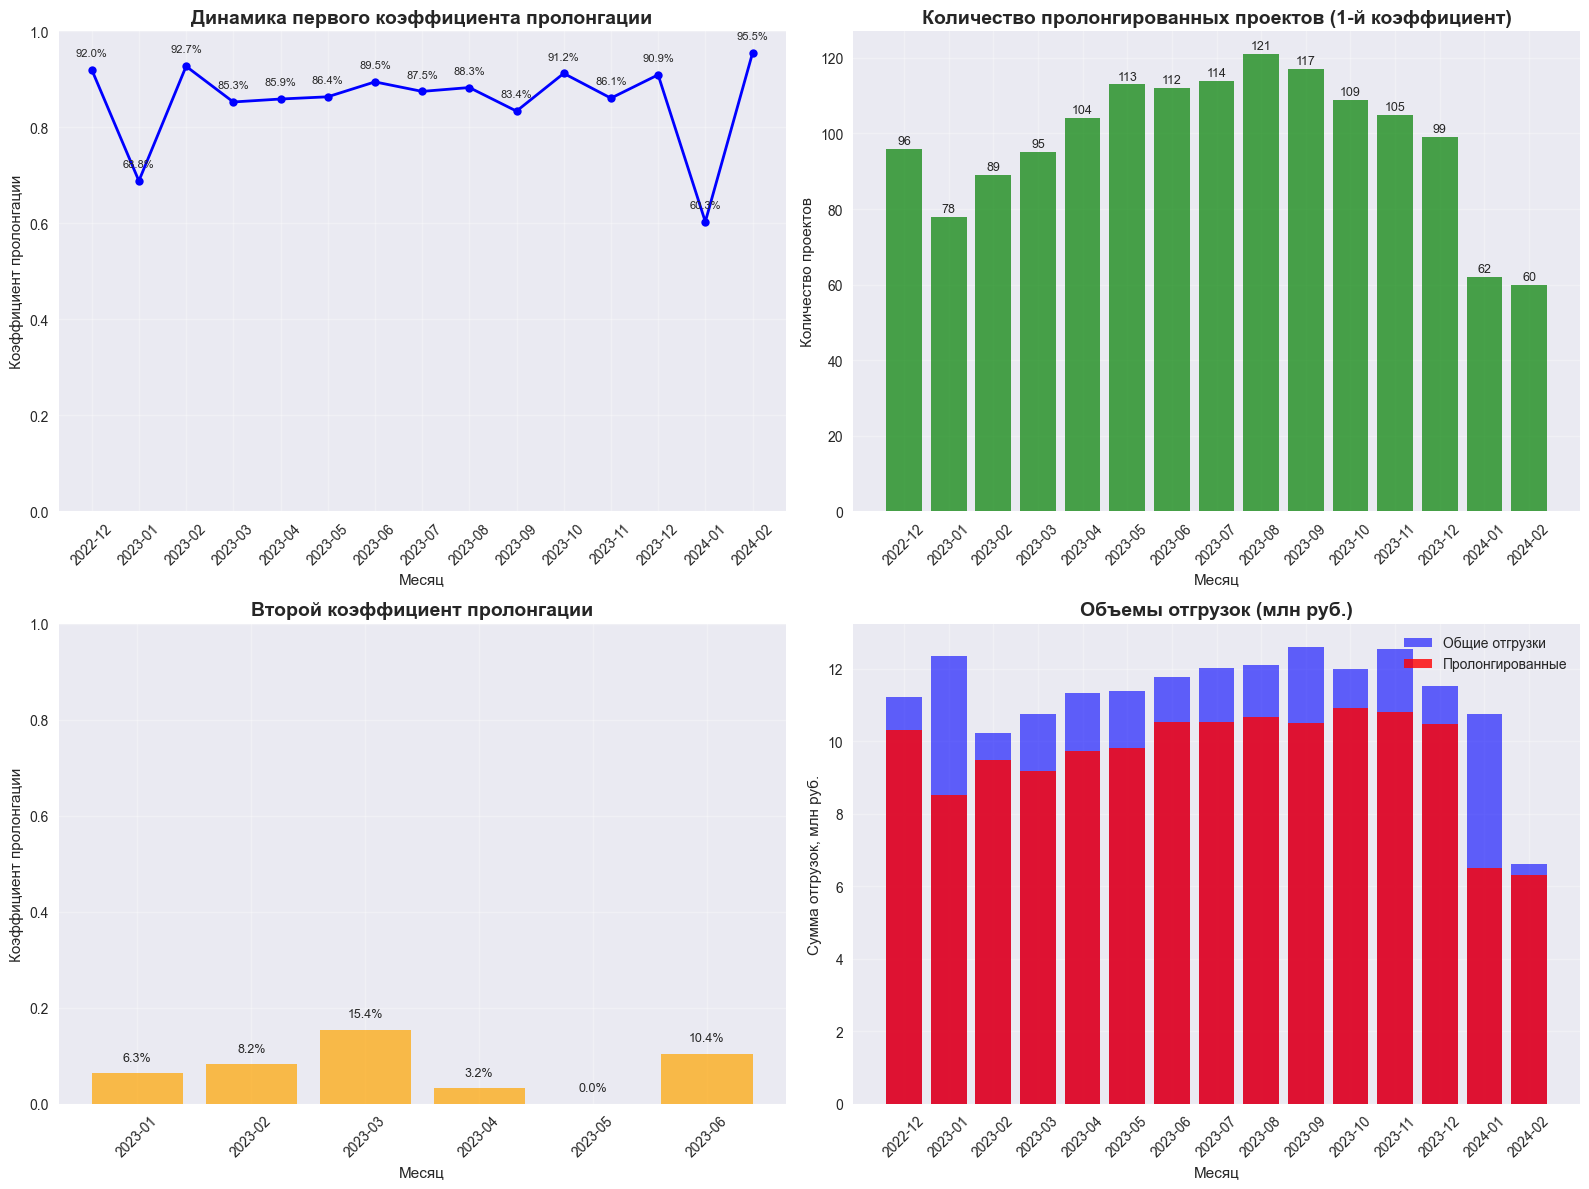

✅ Графики сохранены в improved_prolongation_analysis.png

💾 СОЗДАНИЕ КОМПЛЕКСНОГО ОТЧЕТА
✅ Комплексный отчет сохранен в comprehensive_prolongation_report.xlsx

📈 СВОДНАЯ СТАТИСТИКА
📊 ОБЩИЕ РЕЗУЛЬТАТЫ:
   • Средний коэффициент пролонгации (1-й): 85.58%
   • Всего пролонгировано проектов: 1474
   • Общий объем пролонгированных отгрузок: 144,285,888 руб.
   • Анализированный период: 2022-12 - 2024-02
   • Средний коэффициент пролонгации (2-й): 7.25%

🏆 ЛУЧШИЕ МЕСЯЦЫ ПО ПРОЛОНГАЦИИ:
   • 2024-02: 95.46% (60 проектов)
   • 2023-02: 92.72% (89 проектов)
   • 2022-12: 92.04% (96 проектов)

🎉 ПОЛНЫЙ АНАЛИЗ ЗАВЕРШЕН!
📁 Созданные файлы:
  1. improved_prolongation_analysis.png - Графики анализа
  2. comprehensive_prolongation_report.xlsx - Полный отчет

📊 ОСНОВНЫЕ РЕЗУЛЬТАТЫ:
  • Проанализировано месяцев: 15
  • Рассчитано вторых коэффициентов: 6
  • Проанализировано менеджеров: 8
  • Второй коэффициент показывает проекты, которые 'вернулись' после пропуска месяца

📈 РЕКОМЕНДАЦИИ ДЛЯ РУКОВОДИТЕЛЯ

In [12]:
# ЗАПУСК ПРОГРАММЫ
if __name__ == "__main__":
    print("🎯 ЗАПУСК ПОЛНОГО АНАЛИЗА ПРОЛОНГАЦИИ")
    print("=" * 50)
    
    first_coeff, second_coeff, manager_results = calculate_complete_prolongation_analysis()

    print("\n🎉 ПОЛНЫЙ АНАЛИЗ ЗАВЕРШЕН!")
    print("=" * 60)
    print("📁 Созданные файлы:")
    print("  1. improved_prolongation_analysis.png - Графики анализа")
    print("  2. comprehensive_prolongation_report.xlsx - Полный отчет")
    print("\n📊 ОСНОВНЫЕ РЕЗУЛЬТАТЫ:")
    print(f"  • Проанализировано месяцев: {len(first_coeff)}")
    print(f"  • Рассчитано вторых коэффициентов: {len(second_coeff)}")
    print(f"  • Проанализировано менеджеров: {manager_results['manager'].nunique() if len(manager_results) > 0 else 0}")

    if second_coeff:
        print(f"  • Второй коэффициент показывает проекты, которые 'вернулись' после пропуска месяца")

    print("\n📈 РЕКОМЕНДАЦИИ ДЛЯ РУКОВОДИТЕЛЯ:")
    print("  • Используйте comprehensive_prolongation_report.xlsx для детального анализа")
    print("  • Сравните эффективность менеджеров по коэффициентам пролонгации")
    print("  • Проанализируйте причины различий в первом и втором коэффициентах")
    print("  • Обратите внимание на проекты, которые 'возвращаются' после перерыва")
    print("  • Разработайте план улучшения на основе выявленных закономерностей")